In [1]:
# Tugas Besar IF3270 Pembelajaran Mesin
# Anggota Kelompok:
# 1. Gede Prasidha Bhawarnawa - 13520004

# Section Tugas Besar A: Implementasi Forward Propagation untuk Feed Forward Neural Network (FFNN)

# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# Softmax Activation Function Implementation
def softmax(arr):
    numerator = np.exp(arr)
    denominator = np.sum(numerator)
    return numerator / denominator

In [3]:
# Sigmoid Activation Function Implementation
def sigmoid(arr):
    numerator = np.exp(arr)
    denominator = numerator + 1
    return numerator / denominator

In [4]:
# Linear Activation Function Implementation
def linear(arr):
    return arr

In [5]:
# Rectified Linear Unit (ReLU) Activation Function Implementation
def relu(arr):
    for i in range(len(arr)):
        if arr[i] < 0:
            arr[i] = 0
    return arr

In [6]:
# Format for the model input:

# number_of_layers(INT)
# number_of_nodes_in_layer_1(INT)
# number_of_nodes_in_layer_2(INT)
# ...
# number_of_nodes_in_layer_n(INT)
# number_of_output_nodes(INT)
# loop for all nodes except output (
# node_number, node_type, node_level, node_value, activation_function, node_weight_1, node_weight_2, ..., node_weight_n
# )

# Number of layers doesn't include the input layer and the output layer
# When counting input_nodes, include the bias node also.
# There are four node_types: bias, input, hidden
# If the node_type is bias, then the node_value must be 1 or the program will exit with error message. It's activation function doesn't matter
# If the node_type is input, then the node_value must be the input value and the node_level must be 0. It's activation function doesn't matter
# If the node_type is hidden, then the node_value doesn't matter and the node_level must be greater than 0
# Output nodes will be created automatically based on the number of output nodes
# All counts start from 0, including the node_level and node_numbering (will be done behind-the-scenes)
# The activation_function must be one of the following: linear, sigmoid, relu, softmax
# The number of node_weights declared in each node must be the same as the number of nodes in the next layer/level
# Note: For each node information, DO NOT USE WHITESPACES

# Example:

# 2 (number_of_layers)
# 3 (number_of_nodes_in_layer_1)
# 2 (number_of_nodes_in_layer_2)
# 2 (number_of_output_nodes)
# 0,bias,0,1,linear,4:0.5,5:-0.2,6:0.3 (bias input node in layer 1)
# 1,input,0,12,linear,4:0.2,5:-0.1,6:0.1 (#1 input node in layer 1)
# 2,input,0,3,linear,4:0.1,5:0.2,6:0.3 (#2 input node in layer 1)
# 3,bias,1,1,linear,8:0.1,9:0.2 (bias input node in layer 2)
# 4,hidden,1,0,linear,8:0.1,9:0.2 (#1 hidden node in layer 2)
# 5,hidden,1,0,relu,8:-0.4,9:-0.7 (#2 hidden node in layer 2)
# 6,hidden,1,0,softmax,8:0.5,9:-0.3 (#3 hidden node in layer 2)
# 7,bias,2,1,linear,10:0.1,11:0.2 (bias input node in layer 3)
# 8,hidden,2,0,linear,10:0.2,11:0.1 (#1 hidden node in layer 3)
# 9,hidden,2,0,relu,10:-0.1,11:-0.1 (#2 hidden node in layer 3)

# For the case above, total number of nodes declared in the text file is 10
# The number of nodes in each layer is 3, 4, 3
# Again note that no output nodes are declared in the text file, they will be created automatically

In [7]:
# Node Class and Instances
class Node:
    def __init__(self, node_number, node_type, node_level, activation_function, weight, node_value=0):
        self.node_number = node_number
        self.node_type = node_type
        self.node_value = node_value # For non-input nodes, this value is 0
        self.node_level = node_level
        self.activation_function = activation_function
        self.weight = weight
        self.output = 0
        self.error = 0
    
    def getNodeNumber(self):
        return self.node_number
    
    def getNodeType(self):
        return self.node_type
    
    def getNodeValue(self):
        return self.node_value
    
    def setNodeValue(self, node_value):
        self.node_value = node_value
    
    def getNodeLevel(self):
        return self.node_level
    
    def getActivationFunction(self):
        return self.activation_function
    
    def getActivationFunctionValue(self, value):
        if self.activation_function == "linear":
            return linear(value)
        elif self.activation_function == "sigmoid":
            return sigmoid(value)
        elif self.activation_function == "relu":
            return relu(value)
        else: # Uses softmax
            return softmax(value)
    
    def getWeight(self):
        return self.weight
    
    def getStrWeight(self):
        return str(self.weight)
    
    def getNextLayerNodeNumbers(self, nodes):
        next_layer_nodes = []
        for node in nodes:
            if node.getNodeLevel() == self.node_level + 1:
                next_layer_nodes.append(node.getNodeNumber())
        return next_layer_nodes
    
    def getNodeInfo(self):
        print("Node Number: ", self.node_number)
        print("Node Type: ", self.node_type)
        print("Node Value: ", self.node_value)
        print("Node Level: ", self.node_level)
        print("Activation Function: ", self.activation_function)
        print("Weight: ", self.weight)
        print()

In [8]:
class Model:
    def __init__(self, number_of_layers:int, number_of_nodes:int, nodes:list, expected_results:list, max_sse:float):
        self.number_of_layers = number_of_layers
        self.number_of_nodes = number_of_nodes
        self.nodes = nodes # We assume that bias are also nodes of value 1
        self.expected_results = expected_results
        self.max_sse = max_sse
    
    def getNumberOfLayers(self):
        return self.number_of_layers
    
    def getNumberOfNodes(self):
        return self.number_of_nodes
    
    def getNodeList(self):
        return self.nodes
    
    def getNodeByIndex(self, index):
        return self.nodes[index]
    
    def setNodeValueByIndex(self, index, node_value):
        self.nodes[index].setNodeValue(node_value)
    
    def getNodeByLevel(self, layer):
        nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == layer:
                nodes.append(node)
        return nodes
    
    def getExpectedResults(self):
        return self.expected_results
    
    def getMaxSSE(self):
        return self.max_sse

    def getModelInfo(self):
        print("Number of Layers: ", self.number_of_layers)
        print("Number of Nodes: ", self.number_of_nodes) # Bias is also counted as a node here
        print("Nodes: ")
        for node in self.nodes:
            node.getNodeInfo()
    
    def printModelSummary(self):
        print("Model Summary:")
        print("---------------------------------------------------")
        print("{:^10} | {:^10} | {:^10} | {:^10} | {:^10}".format("Node Number", "Node Type", "Layer Depth", "Activation Function", "Weight"))
        for level in range(0,self.number_of_layers+2):
            nodes = self.getNodeByLevel(level)
            for node in nodes:
                print("{:^10d} | {:^10s} | {:^10d} | {:^10s} | {:^10s}".format(node.getNodeNumber(), node.getNodeType(), node.getNodeLevel(), node.getActivationFunction(), node.getStrWeight()))
        print("---------------------------------------------------")
        print("Expected Results: ", str(self.expected_results))
        print("Max SSE: ", self.max_sse)
    
    def getInputNodeNumbers(self):
        input_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == 0 and node.getNodeType() == "input":
                input_nodes.append(node.getNodeNumber())
        return input_nodes
    
    def getOutputNodeValues(self):
        output_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == self.number_of_layers + 1:
                output_nodes.append(node.getNodeValue())
        return output_nodes
    
    def printModelVisualization(self):
        edge_list = []
        layer_dict = {}
        for node in self.nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(self.nodes)
            for next_layer_node in next_layer_nodes:
                if self.getNodeByIndex(next_layer_node).getNodeType() == "bias":
                    pass
                else:
                    edge_pair = (node.getNodeNumber(), next_layer_node)
                    if edge_pair not in edge_list:
                        edge_list.append(edge_pair)
            layer_dict[node.getNodeNumber()] = node.getNodeLevel()
        G = nx.Graph(edge_list)
        nx.set_node_attributes(G, layer_dict, "layer")
        pos = nx.multipartite_layout(G, subset_key="layer", align="vertical")
        nx.draw(G, pos=pos,with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='white', font_weight='bold')
        plt.title("Feed-forward Neural Network Model Representation")
        plt.show()

In [15]:

# File reader and parser
from itertools import islice
import re
import sys
def readFile(filename):
    nodes =[]
    with open(filename, 'r') as f:
        contents = f.readlines()
        f.close()
    number_of_layers = int(contents[0])
    node_counts = []
    for idx in range(1, number_of_layers+1):
        node_counts.append(int(contents[idx]))
    number_of_nodes = sum(node_counts)
    for idx in range(number_of_layers+1, len(contents) - 2):
        node_info = contents[idx].split(',')
        node_number = int(node_info[0])
        node_type = node_info[1]
        node_level = int(node_info[2])
        node_value = float(node_info[3])
        activation_function = node_info[4]
        # weight = [float(x) for x in node_info[5:]]
        if node_type != 'output':
            weights = {}
            for weight in node_info[5:]:
                weight_info = weight.split(':')
                weights[int(weight_info[0])] = float(weight_info[1])
        else:
            weights = {}
        condition1 = node_type == 'bias' and node_value == 1
        condition2 = node_type == 'input' and node_level == 0
        condition3 = node_type == 'hidden' and node_level > 0
        condition4 = node_type == 'output' and node_level == number_of_layers + 1 
        if condition1 or condition2 or condition3 or condition4:
            nodes.append(Node(node_number, node_type, node_level, activation_function, weights, node_value))
        else:
            print("Invalid node information found in line: ", idx + 1)
            sys.exit(1)
    expected_results = contents[-2].strip().split(',')
    expected_results = [float(x) for x in expected_results]
    max_sse = float(contents[-1])
    result = Model(number_of_layers, number_of_nodes, nodes, expected_results, max_sse)
    # result.getModelInfo()
    result.printModelSummary()
    result.printModelVisualization()
    return result
    

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.4, 4: 0.2, 5: 0.1}
    1      |   input    |     0      |            | {3: 0.2, 4: 0.4, 5: 0.2}
    2      |   input    |     0      |            | {3: 0.1, 4: 0.2, 5: 0.4}
    3      |   output   |     1      |  sigmoid   |     {}    
    4      |   output   |     1      |  sigmoid   |     {}    
    5      |   output   |     1      |  sigmoid   |     {}    
---------------------------------------------------
Expected Results:  [0.617747, 0.58904, 0.574442]
Max SSE:  1e-06


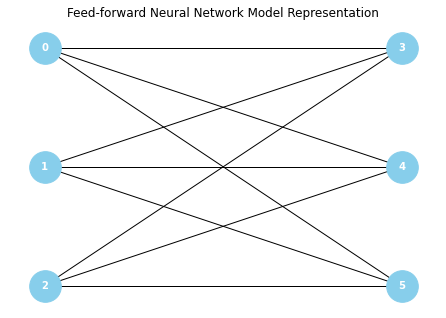

In [16]:
model = readFile('sigmoidModel.txt')
#TODO: Hias lebih bagus graph (bedain bias, input, sama output)

In [19]:
# Fill all input nodes with values and then feed the values to the nodes of the next layer
input_nodes = model.getInputNodeNumbers()
data = np.genfromtxt('dataSigmoid.csv', delimiter=',')

if len(data) != len(input_nodes):
    print("Number of input nodes and number of features are not equal")
    sys.exit(1)
    
for idx in range(len(data)):
    model.setNodeValueByIndex(input_nodes[idx], data[idx])

for layer in range(0, model.getNumberOfLayers()+1):
    # Get all nodes in the layer and then one by one feed the values to the next layer
    # At first the values will be based purely on the node's values and its weights
    # Then it will be passed to the activation function to get the final value
    nodes = model.getNodeByLevel(layer)
    next_node_values = {}
    for node in nodes:
        for next_node_key in node.getWeight().keys():
            if next_node_key not in next_node_values.keys():
                next_node_values[next_node_key] = node.getWeight()[next_node_key] * node.getNodeValue()
            else:
                next_node_values[next_node_key] += node.getWeight()[next_node_key] * node.getNodeValue()
    for next_node_key in next_node_values.keys():
        next_node = model.getNodeByIndex(next_node_key)
        next_node_value = next_node_values[next_node_key]
        next_node_value = next_node.getActivationFunctionValue(next_node_value)
        next_node.setNodeValue(next_node_value)
        next_node_values[next_node_key] = next_node_value

final_results = model.getOutputNodeValues()
print("Raw final results: ", [x.tolist() for x in np.array(final_results)])
# Compare the results with the expected results
expected_results = model.getExpectedResults()


Raw final results:  [0.617747874769249, 0.5890404340586651, 0.574442516811659]
Rounded final results:  [1.0, 1.0, 1.0]


In [ ]:
# Printing the final results
print("Final Results:")
format_header = "{:^10} | " * model.getInputNodeNumbers().__len__()

Final Results:
{:^10} | {:^10} | 
